## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [25]:
# importing required libraries.

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [26]:
# loading the dataset into a dataframe.

df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [27]:
# getting the dataset shape.
# The dataset has294478 rows.

df.shape[0]

294478

c. The number of unique users in the dataset.

In [28]:
# The number of the unique users in the dataset is 290584.

df.user_id.nunique()

290584

d. The proportion of users converted.

In [29]:
# Overall proportion is 11.97%.

df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [41]:
# The Number of times where the newpage and treatment match up: 3893

control_page = df.query("group == 'control' and landing_page == 'new_page'").shape[0]
treatment_page = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
control_page, treatment_page, treatment_page + control_page

(1928, 1965, 3893)

f. Do any of the rows have missing values?

In [42]:
# count of the missing values.
# There are no missing values in the dataset.

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [43]:
# dropping the different where the new page anf treatment do nto match up

df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [44]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [50]:
# The number of the unique users in the dataframe is :290585.

df2.user_id.count()

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [51]:
# User_ID repeted in the dataframe:773192

df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [54]:
# Retrieving 773192 user_id rows information
# difference only in timestamp

df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [55]:
# Dropping duplicated  user id, will keep the one with recent timestamp
# removing 1899.

df2.drop([1899], inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [59]:
# Probability of conversion

df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [79]:
# Probability of conversion in control group

control_conversion = df2.query('group == "control"')['converted'].mean()
control_conversion

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [80]:
# Probability of conversion in treatment group

treatment_conversion = df2.query('group == "treatment"')['converted'].mean()
treatment_conversion

0.11880806551510564

d. What is the probability that an individual received the new page?

In [61]:
# Probability of receiveing new page

new_page = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

>**With the overall conversion of `11.96%` and `12.04` conversion for the old page and `11.88%` for the new page, there is a slight difference between the two pages with better conversion rate from the old page even though it's a small difference, we can say the old page is better than the new page so it's better to keep it.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

##### The $H_{0}$: The new page is equal or less affective than the old page.

##### The $H_{1}$: The new page is better than the old page.


$$H_0: p_{new} <= p_{old}$$
$$H_1: p_{new}  > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [62]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [63]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [64]:
n_new = df2.query("group == 'treatment'")["converted"].count()
n_new

145310

d. What is $n_{old}$?

In [65]:
n_old = df2.query("group == 'control'")["converted"].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [89]:
#performing random binomial for p_new.

new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [88]:
#performing random binomial for p_old.

old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([1, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [90]:
# Calculating difference between p_new - p_old

o_diff = new_page_converted.mean() - old_page_converted.mean()
o_diff

8.034897616439329e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [91]:
p_diffs = []
new_page_converted = np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,10000)/n_new
old_page_converted = np.random.binomial(n_old,𝑝_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted 
p_diffs

array([ 0.00060366,  0.00059659, -0.00081432, ...,  0.00017688,
        0.00220721, -0.00139237])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [92]:
# Getting the conversion difference p_new and p_old.

obs_diff = treatment_conversion - control_conversion
obs_diff

-0.0015782389853555567

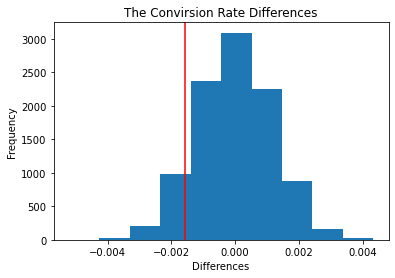

In [93]:
# poltting simulation of 10000.
plt.hist(p_diffs)
plt.title("The Convirsion Rate Differences")
plt.xlabel("Differences")
plt.ylabel("Frequency")
plt.axvline(x=(obs_diff), color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [97]:
#  The mean of p_diffs is greater than the diffrence observed in the ab_data.csv

(p_diffs > obs_diff).mean()

0.9057

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**This is where the statistics observation is.the value called P-value and with `0.9057` P-value we can say we failed to reject the null hypothesis 
the P-value need to be more than 0.05 to reject the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [95]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()
convert_new = df2.query('landing_page == "new_page" and converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [96]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value


(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**zscore it tell us how many std from the mean**
>
>**P-value is `0.91` and yes they agree with the finding in (j.)and (k.)**
>


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [98]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [99]:
# Creating intercept column for regression

df2['intercept'] = 1

# Creating dummies.

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [102]:
# Logistic regression model.

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# Fittign the model.

result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [103]:
# Outline summary.

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:23:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} !=0$$

**The `P-value: 0.190`, the difference is that logistic regression is a two tailed test but the previous test is 1 tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more variables to the regression will give us more accurate results because of:**
>
> * Change Aversion: Users may give an unfair advantage to the control group or maybe not happy with the changes
>
>
> * Novelty Effect: Users may give an unfair advantage to the treatment group because they’re excited or drawn to the change, even if it isn’t any better in the long run.

**so adding more factors will give better understanding**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [107]:
# Reading data from countries.csv

df_c = pd.read_csv('countries.csv')
df_c.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [110]:
# Country list.

df_c.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [113]:
# Mergeing the datasets based on user_id

df_c2 = df2.join(df_c.set_index('user_id'), on = 'user_id')

In [114]:
# Createing the necessary dummy variables

df_c2[['CA_ab_page','UK_ab_page','US_ab_page']] = pd.get_dummies(df_c2['country'])

df_c2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA_ab_page,UK_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [116]:
# Fitting model and outline the results

log_mod2 = sm.Logit(df_c2['converted'],df_c2[['intercept','US_ab_page','UK_ab_page']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:               1.521e-05
Time:                        00:55:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US_ab_page     0.0408      0.027      1.518      0.129      -0.012       0.093
UK_ab_page     0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

>
>P-values higher than 0.05 and that mean we fail to reject the null. 
> 
>Old page performance was better than the new page with very slight difference. 
>
>We need to run the test more or to add more variables to the test to get better results.
>
